In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os
import scvi

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

Global seed set to 0


In [2]:
DIR2SAVE = Path(
    "/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/subpopulations/TNKILC"
)

In [3]:
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [4]:
# load general annotations to isolate T-NK-ILC cells only
general_annot = pd.read_csv(
    "/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/annotation_global/SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg_annotations_general.txt",
    header=0,
    sep="\t",
    index_col=0,
)

In [5]:
# these are the cells we need to extract from the raw data to get raw counts
idx2extract = general_annot[general_annot.Annotation_scVI == "T-NK-ILC"].index

In [6]:
# load raw counts from merged object
adata_raw = sc.read_h5ad(
    "/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/data_integration/SMC_KUL_Pelka_Che_Wu_CRC_raw.h5ad"
)

In [7]:
# select from the raw data only the barcodes of interest, select raw counts from cell population of interest
adata = adata_raw[adata_raw.obs.index.isin(idx2extract)].copy()
adata.shape

(101060, 38118)

In [8]:
# check that it is raw data
np.max(adata.X)

2527.0

In [9]:
adata.obs.Patient.value_counts()

COL07         7223
COL12         6798
COL17         5688
COL18         3527
C132_T        3399
              ... 
C165_T          14
C159_T          11
KUL30            2
Wu2021_P20       2
C161_T           1
Name: Patient, Length: 117, dtype: int64

### Normalise + log transform + HVG

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data.


In [10]:
# keep raw
adata.layers["raw"] = adata.X.copy()  # preserve counts

# normalize + log1p
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)
adata.layers["normalised"] = adata.X.copy()
sc.pp.log1p(adata)

adata.layers["log1p"] = adata.X.copy()

The count data has been normalized and log-transforme d with an offset of 1. The latter is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros. We keep this data in the '.raw' part of the AnnData object as it will be used to visualize gene expression and perform statistical tests such as computing marker genes for clusters.

In [11]:
adata.raw = adata  # keep normalised log1p

### HVG 
We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

**Expects logarithmized data, except when `flavor='seurat_v3'` in which
count data is expected.**

In [12]:
sc.pp.highly_variable_genes(
    adata,
    subset=True,  # subset for integration (but full lognorm data in .raw)
    layer="raw",
    flavor="seurat_v3",
    n_top_genes=2000,
    span=0.3,
    min_disp=0.5,
    min_mean=0.0125,
    max_mean=3,
    batch_key="cell_source",
)

In [13]:
adata.X.shape

(101060, 2000)

In [14]:
adata.raw.to_adata().X.shape

(101060, 38118)

### scVI
Unless otherwise specified, scvi-tools models require the raw counts (not log library size normalized).

Now it’s time to run setup_anndata(), which alerts scvi-tools to the locations of various matrices inside the anndata. It’s important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a “cell_source” categorical covariate, and within each “cell_source”, multiple “patients”. There are also two continuous covariates we’d like to correct for: “percent_mito” and “percent_ribo”. These covariates can be registered using the categorical_covariate_keys argument. If you only have one categorical covariate, you can also use the batch_key argument instead.



In [15]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="raw",
    categorical_covariate_keys=["cell_source", "Patient"],
    continuous_covariate_keys=[
        "pct_counts_mt",
        "pct_counts_ribo",
    ],  # add cell cycle here if you want to correct for this
)

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/data/_utils.py:156: UserWarning: Category 50 in adata.obs['Patient'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


#### Creating and training a model

In [16]:
model = scvi.model.SCVI(adata)
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

In [17]:
model.train()

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - 

Epoch 79/79: 100%|██████████| 79/79 [11:43<00:00,  8.90s/it, loss=425, v_num=1]


In [19]:
# save model
model.save(os.path.join(DIR2SAVE, "scvi_model_hvg_mt_ribo"))

In [20]:
# read the model
model = scvi.model.SCVI.load(
    os.path.join(DIR2SAVE, "scvi_model_hvg_mt_ribo"), adata=adata
)  # , use_gpu=True)

INFO     File /data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/subpopulations/TNKILC/scvi_m
         odel_hvg_mt_ribo/model.pt already downloaded                                        


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/data/_utils.py:156: UserWarning: Category 50 in adata.obs['Patient'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


In [21]:
latent = model.get_latent_representation()  # get model output

In [22]:
latent.shape

(101060, 10)

In [23]:
# It’s often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with
# Scanpy.
adata.obsm["X_scVI"] = latent

In [24]:
# Let’s store the normalized values back in the anndata.
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    adata=adata, library_size=1e4
)

### Visualization without batch correction

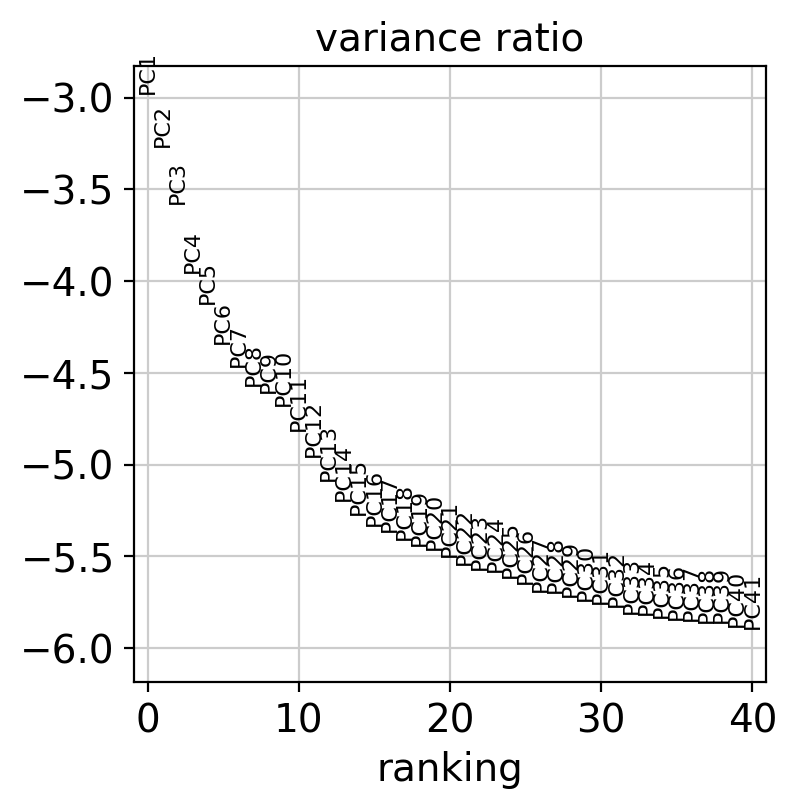

In [25]:
# perform PCA on adata_liver (which contains only HVG (after normalized, log1p) and scaled
sc.tl.pca(adata, svd_solver="arpack", use_highly_variable=True, random_state=7)

# Elbow plot
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=40, show=True)

# compute neighbourhood graph
sc.pp.neighbors(
    adata,
    n_neighbors=15,
    n_pcs=15,
    knn=True,
    method="umap",
    metric="euclidean",
    random_state=7,
)

# compute UMAP embedding
sc.tl.umap(adata, min_dist=0.3, n_components=2, random_state=7)

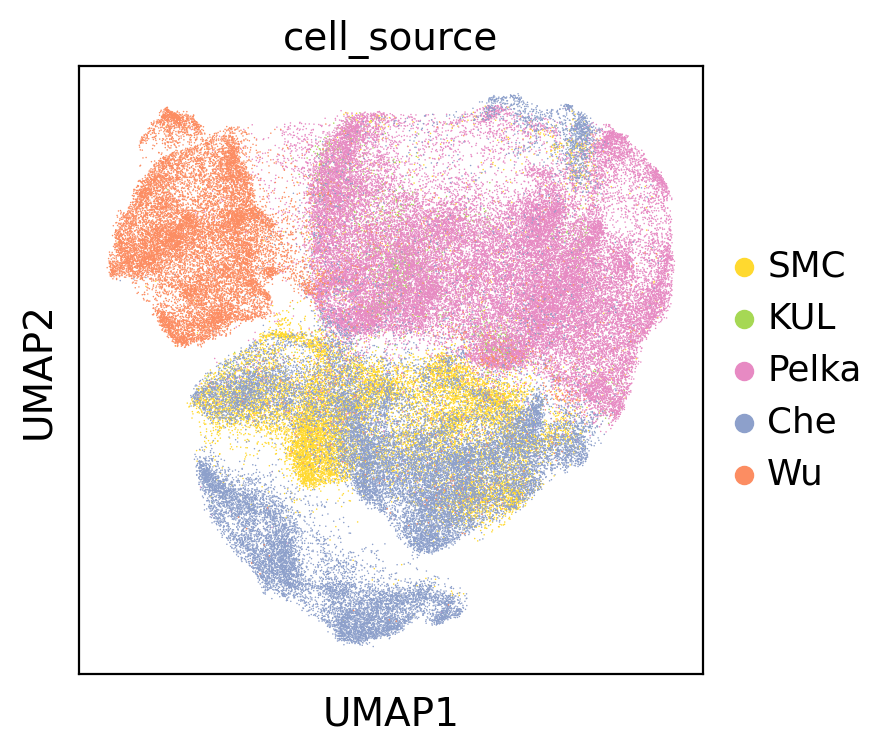

In [26]:
sc.pl.umap(adata, color="cell_source", save="before_integration_scvi.pdf", show=True)

### With batch correction - scVI

In [29]:
print("Number of PCs:", latent.shape[1])
# use scVI latent space for UMAP generation
# set nb pcs to latent representation shape of scvi
# compute neighbourhood graph
sc.pp.neighbors(
    adata,
    n_neighbors=15,
    n_pcs=latent.shape[1],
    knn=True,
    method="umap",
    metric="euclidean",
    use_rep="X_scVI",
    random_state=7,
)

# compute UMAP embedding
sc.tl.umap(adata, min_dist=0.3, n_components=2, random_state=7)

Number of PCs: 10


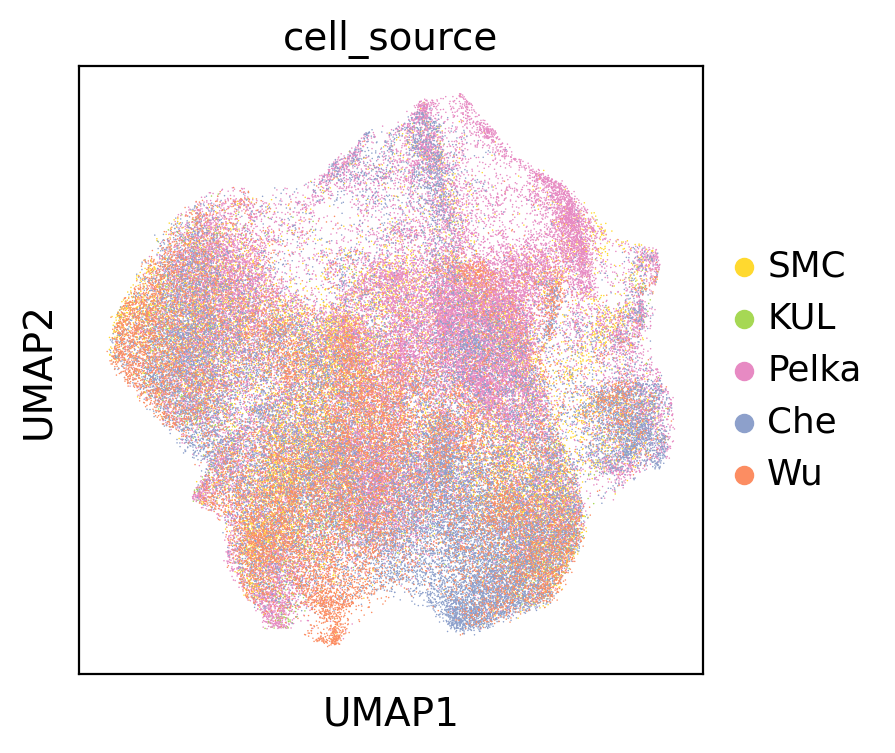

In [30]:
sc.pl.umap(adata, color="cell_source", save="after_integration_scvi.pdf", show=True)

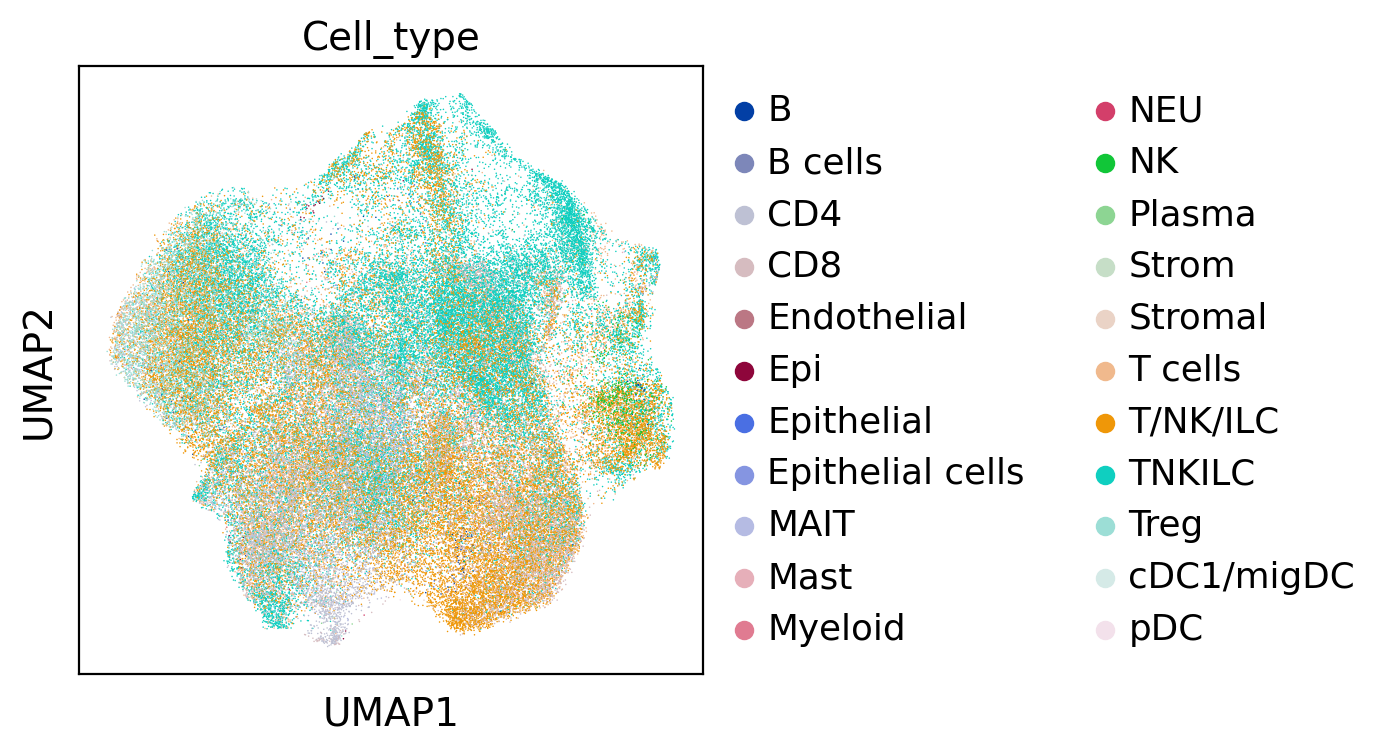

In [31]:
sc.pl.umap(adata, color="Cell_type")

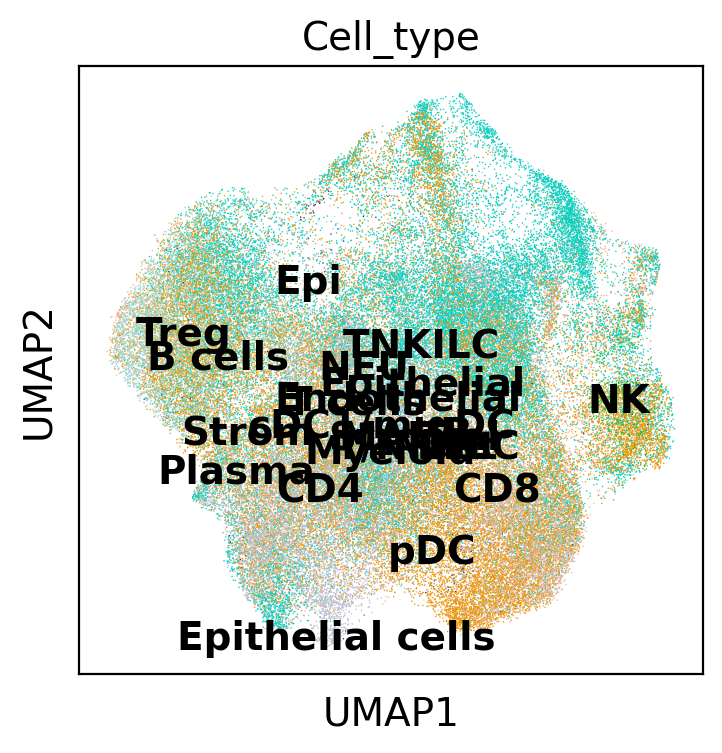

In [32]:
sc.pl.umap(adata, color="Cell_type", legend_loc="on data")

In [8]:
# save to file
adata.write(
    DIR2SAVE.joinpath("SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg_TNKILC.h5ad")
)

In [35]:
adata.obs.Cell_type.value_counts()

TNKILC              39305
T/NK/ILC            26707
T cells             18198
CD4                  7021
CD8                  4744
Treg                 3253
MAIT                  967
NK                    453
B                     194
Epithelial             78
Myeloid                37
Epi                    32
Plasma                 24
Mast                   18
pDC                     6
Stromal                 5
Strom                   5
B cells                 3
Epithelial cells        3
Endothelial             3
NEU                     3
cDC1/migDC              1
Name: Cell_type, dtype: int64